In [25]:
#pip install yfinance

In [67]:

import pandas as pd 
import numpy as np
import yfinance as yf 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier # robust overfiting with right parameters and identify non-linear relationships
from sklearn.metrics import accuracy_score, precision_score

import warnings
warnings.filterwarnings('ignore')


In [76]:
# Yahoo Finance load data into DataFrame automatically
msft = yf.Ticker('MSFT')
msft_hist = msft.history(period='max')
msft_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.055654,0.063838,0.055654,0.061109,1031788800,0.0,0.0
1986-03-14,0.061109,0.064384,0.061109,0.063292,308160000,0.0,0.0
1986-03-17,0.063292,0.064929,0.063292,0.064384,133171200,0.0,0.0
1986-03-18,0.064384,0.064929,0.062201,0.062746,67766400,0.0,0.0
1986-03-19,0.062746,0.063292,0.061109,0.061655,47894400,0.0,0.0


<AxesSubplot:xlabel='Date'>

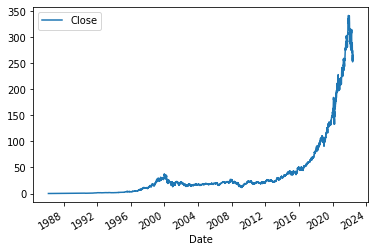

In [77]:
# visual close price
msft_hist.plot.line(y='Close', use_index=True)

In [78]:
msft_hist.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,9128.000000,9128.000000,9128.000000,9128.000000,9.128000e+03,9128.000000,9128.000000
mean,37.358121,37.745015,36.954472,37.364390,5.862268e+07,0.002547,0.001862
std,62.118250,62.730875,61.444565,62.120593,3.840492e+07,0.043206,0.059644
min,0.055654,0.057836,0.055654,0.056745,2.304000e+06,0.000000,0.000000
25%,2.759750,2.802717,2.733970,2.764046,3.445168e+07,0.000000,0.000000
50%,18.951305,19.144649,18.734078,18.942552,5.191135e+07,0.000000,0.000000
75%,29.443870,29.766751,29.074550,29.440580,7.245038e+07,0.000000,0.000000
max,343.109746,348.137633,340.700399,341.606384,1.031789e+09,3.080000,2.000000


In [79]:
msft_hist.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9128 entries, 1986-03-13 to 2022-05-27
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          9128 non-null   float64
 1   High          9128 non-null   float64
 2   Low           9128 non-null   float64
 3   Close         9128 non-null   float64
 4   Volume        9128 non-null   int64  
 5   Dividends     9128 non-null   float64
 6   Stock Splits  9128 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 570.5 KB


In [80]:
msft_hist.isnull().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

# Preparing the data for machine learning


In [81]:
# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]


In [82]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

In [83]:
# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

In [56]:
# Combine target and predict with predictors, remember to remove the first NaN row of msft_prev
predictors = ['Close','High','Low','Open']
data = data.join(msft_prev[predictor]).iloc[1:]
data.head()

,Actualy_close,Target,Close,High,Low,Open
Date,,,,,,
1986-03-14,0.063292,1.0,0.061109,0.063838,0.055654,0.055654
1986-03-17,0.064384,1.0,0.063292,0.064384,0.061109,0.061109
1986-03-18,0.062746,0.0,0.064384,0.064929,0.063292,0.063292
1986-03-19,0.061655,0.0,0.062746,0.064929,0.062201,0.064384
1986-03-20,0.060018,0.0,0.061655,0.063292,0.061109,0.062746


# Training the machine learning model


In [84]:
# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [85]:
# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.4787234042553192

<AxesSubplot:xlabel='Date'>

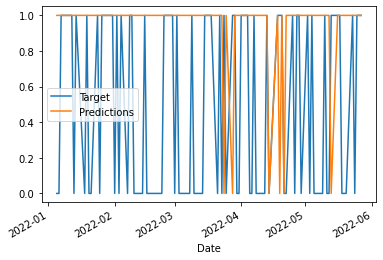

In [86]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

# Creating a backtesting Engine
##looping over data, spliting data up, training new model, and predict for next few row

In [87]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Fit the random forest model
        model.fit(train[predictors], train["Target"])
        
        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        
        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
        
        predictions.append(combined)
    
    return pd.concat(predictions)

In [88]:
predictions = backtest(data, model, predictors)

In [89]:
predictions["Predictions"].value_counts()

0.0    7412
1.0     715
Name: Predictions, dtype: int64

In [90]:
precision_score(predictions["Target"], predictions["Predictions"])

0.4993006993006993

# Improve accuracy of model

In [91]:
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()
weekly_trend = data.shift(1).rolling(7).mean()["Target"]

In [92]:
data["weekly_mean"] = weekly_mean["Close"] / data["Close"]
data["quarterly_mean"] = quarterly_mean["Close"] / data["Close"]
data["annual_mean"] = annual_mean["Close"] / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]



In [93]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]
predictions = backtest(data.iloc[365:], model, full_predictors)

In [94]:
precision_score(predictions["Target"], predictions["Predictions"])

0.6083333333333333

In [95]:
# Show how many trades we would make

predictions["Predictions"].value_counts()

0.0    7522
1.0     240
Name: Predictions, dtype: int64

<AxesSubplot:xlabel='Date'>

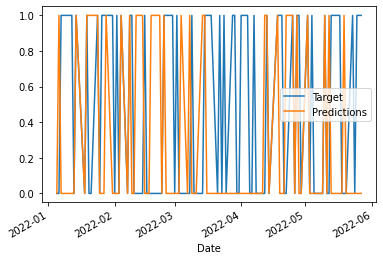

In [96]:
predictions.iloc[-100:].plot()